## 0 Setup

### 0.1 Importing modules

In [2]:
import json
import time
import os
import re
import math
import datetime

import requests
from bs4 import BeautifulSoup
import muspy
import numpy as np
import matplotlib.pyplot as plt

### 0.2 Importing PyTorch and choosing GPU/CPU

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1 Importing data

### 1.1 Find midi

The following goes through a website and looks for any links ending with ".mid". We are using the http://www.jsbach.net/midi archive, but other archives could be used.

In [4]:
base_path_regex = re.compile(r"(https?:\/\/[a-zA-Z0-9\-\.]+(?:\/[a-zA-Z0-9\-\.]+))(.*)")

def find_midi_from_url(url, depth = 1, max_fail = 1, fails = 0, print_error = False, headers = {}, params = {}):
    try: response = requests.get(url=url, params=params, headers=headers)
    except Exception as e:
        if print_error: print(f"Unable to get {url}. Error: {e}")
        return []
    
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    links = [a['href'] for a in soup.find_all('a', href=True)]
    regex_match = base_path_regex.match(url)
    if regex_match: base = regex_match.group(1)
    else: 
        if print_error: print(f"url regex fail: {url}")
        return []
    
    midi_links = [(link if link.startswith("http") else base + "/" + link) for link in links if link.endswith(".mid")]
    
    if not midi_links: fails += 1

    if depth > 0 and fails <= max_fail:
        for link in links:
            if not link.startswith("http"): link = base + "/" + link
            midi_links += find_midi_from_url(link, depth - 1, max_fail, fails)
    
    return midi_links

In [5]:
bach_url = "http://www.jsbach.net/midi"

if not os.path.exists("data/midi_data/bach.json"):
    midi_data = find_midi_from_url(bach_url, 1, 3)
    with open("data/midi_data/bach.json", "w") as file:
        json.dump({"date": str(datetime.date.today()), "data": midi_data}, file, indent=4)

### 1.2 Download midi

In [6]:
def get_midi_from_url(urls: list, time_threshold: int = None, print_error = False, headers = {}, params = {}) -> tuple[list[tuple[str, bytes]], list[str]]:
    time_start = time.time()
    data = []
    errors = []
    for i, url in enumerate(urls):
        regex_match = base_path_regex.match(url)
        path = regex_match.group(2)

        delta_time = time.time() - time_start
        if time_threshold and delta_time > time_threshold:
            print(f"Exceeded time threshold at {round(delta_time, 1)}. \n\tUrls total: {len(urls)} \n\tFound data: {len(data)} \n\tErrors: {i-len(data)}")
            return (data, errors)
        
        try: response = requests.get(url=url, params=params, headers=headers)
        except Exception as e:
            if print_error: print(f"Unable to get {url}. Error: {e}")
            errors.append(path)
            continue
    
        if response.status_code == 200: data.append((path, response.content))
        else:
            if print_error: print(f"response error: {url}")
            errors.append(path)
            continue

    print(f"Finished at {round(delta_time, 1)}. \n\tUrls total: {len(urls)} \n\tFound data: {len(data)} \n\tErrors: {i+1-len(data)}")
    return (data, errors)

In [7]:
with open("data/midi_data/bach.json", "r") as file:
    unfiltered_urls: set[str] = set(json.load(file)["data"])

with open("data/midi_data/bach_errors.json", "r") as file:
    try: error_files: list[str] = json.load(file)["data"]
    except: error_files = []
    error_files = error_files if error_files else []

current_files = [file.replace("_", "/") for file in os.listdir("data/midi_data/files")]
remove_files = set(current_files + error_files)

urls = [url for url in unfiltered_urls if not any([url.endswith(file) for file in remove_files])]
midi_files, new_error_files = get_midi_from_url(urls, 100)

with open("data/midi_data/bach_errors.json", "w") as file:
    json.dump({"data": list(set(error_files + new_error_files))}, file, indent=4)

for file, raw_midi in midi_files:
    path = f"data/midi_data/files/{file[1:].replace("/", "_")}"
    with open(path, "wb") as file:
        file.write(raw_midi)

Finished at 1.4. 
	Urls total: 3 
	Found data: 3 
	Errors: 0


## 2 Transform data

### 2.1 Group by bar and order

In [ ]:
def shift_to_common_key(music: muspy.music.Music):
    if len(music.key_signatures) > 1: return None
    else: 
        try: key_signature = music.key_signatures[0]
        except: return None
    try: key = int(key_signature.root)
    except: return None
    for track in music.tracks:
        for note in track.notes:
            note.pitch += key
    return music

def create_notes(music: muspy.music.Music):
    if not music.time_signatures: return None
    else: time_signature = music.time_signatures[0]
    beats_per_bar = time_signature.numerator
    ticks_per_beat = music.resolution
    bar_length = beats_per_bar * ticks_per_beat

    normalized_notes:dict[int, list] = {}
    for track in music.tracks:
        for note in track.notes:
            normalized_pitch = note.pitch % 12
            bar_count = math.floor(note.time / bar_length)
            if bar_count not in normalized_notes: normalized_notes[bar_count] = list()
            normalized_notes[bar_count].append(normalized_pitch)

    return {key:list(set(values)) for key, values in normalized_notes.items()}

### 2.2 Visualize data

In [57]:
music = muspy.read_midi("test/bach.mid")

plt.imshow(music.to_pianoroll_representation(), cmap='gray', aspect='auto')
plt.axis('off')
plt.show()

notes = create_notes(music)

shape = (12, (len(notes.keys())))
grid = np.zeros(shape)

for bar, notes in notes.items():
    for note in notes:
        grid[note][bar] = 1

plt.imshow(grid, cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

KeyboardInterrupt: 

### 2.3 Create bar data

In [ ]:
data = []
for file in os.listdir("data/midi_data/files"):
    path = os.path.join("data/midi_data/files", file)
    music = muspy.read_midi(path)
    music = shift_to_common_key(music)
    if not music: continue
    notes = create_notes(music)
    if notes: data.append(notes)

with open("data/bar_data.json", "w") as file:
    json.dump({"date": str(datetime.date.today()), "data": data}, file, indent=4)

## 3 Model

### 3.1 Chord model

#### 3.1.1 Prepare data

In [ ]:
with open("data/bar_data.json", "r") as file:
    data: list[dict[int, list]] = json.load(file)["data"]

train_target = []
for score in data:
    score = {int(key): value for key, value in score.items()}
    min_bar = min(score)
    max_bar = max(score)
    for bar_count in score:
        if bar_count < min_bar + 4 or bar_count > max_bar - 4: continue
        vector =  np.zeros((8, 12))
        for i in range(1, 5):
            if bar_count - i in score:
                bar_notes_before = score[bar_count - i]
                for note in range(0, 12): vector[4-i][note] = int(note in bar_notes_before)

            if bar_count + i in score:
                bar_notes_after = score[bar_count + i]
                for note in range(0, 12): vector[3+i][note] = int(note in bar_notes_after)

        target_vector =  np.zeros(12)
        for note in range(0, 12): 
            target_vector[note] = int(note in score[bar_count])
        
        train_target.append((vector.flatten(), target_vector, score[bar_count]))

total_data_size = len(train_target)
print(f"Number of training points: {total_data_size}")

split = int(total_data_size * 0.8)
train, test = train_target[:split], train_target[split:]

train_x = torch.tensor([x for x, _, _ in train], dtype=torch.float32)
train_y = torch.tensor([y for _, y, _ in train], dtype=torch.float32)

test_x = torch.tensor([x for x, _, _ in test], dtype=torch.float32)
test_y = torch.tensor([y for _, y, _ in test], dtype=torch.float32)

Number of training points: 18936


#### 3.1.2. Create Neural Network and loss function

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(96,96),
        nn.ReLU(),
        nn.Linear(96,32),
        nn.ReLU(),
        nn.Linear(32, 12),
        )

    def forward(self, x):
        x = self.net(x)
        return torch.sigmoid(x)
                
relax_penalty = 4

def initial_loss_function(pred, target):
    diff = target - pred
    return (diff + (relax_penalty**2 / (diff + relax_penalty)) - relax_penalty).mean()
    

#### 3.1.3 Training

Epoch 100, Loss: 0.2248382568359375, Accuracy: 0.06535515934228897
Epoch 200, Loss: 0.17817959189414978, Accuracy: 0.06964615732431412
Epoch 300, Loss: 0.17400532960891724, Accuracy: 0.15018483996391296
Epoch 400, Loss: 0.17026843130588531, Accuracy: 0.17474253475666046
Epoch 500, Loss: 0.16583365201950073, Accuracy: 0.16021917760372162
Epoch 600, Loss: 0.16139192879199982, Accuracy: 0.1300501674413681
Epoch 700, Loss: 0.15770351886749268, Accuracy: 0.10991550236940384
Epoch 800, Loss: 0.15463143587112427, Accuracy: 0.10060734301805496
Epoch 900, Loss: 0.1520005315542221, Accuracy: 0.09605228155851364
Epoch 1000, Loss: 0.1498280167579651, Accuracy: 0.09440190345048904


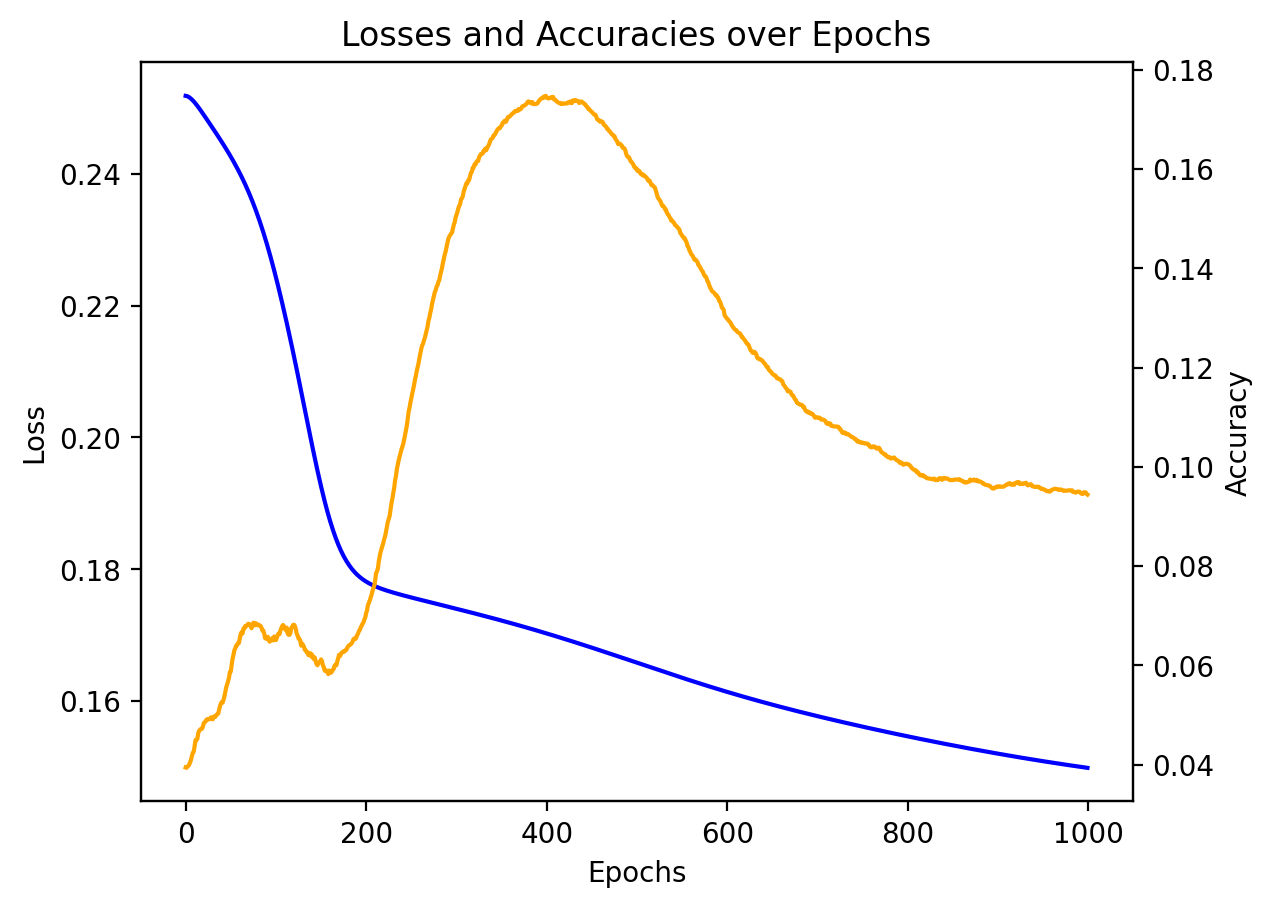

In [ ]:
chord_model = Net().to(device)
optimizer = torch.optim.SGD(chord_model.parameters(), lr=0.05, momentum=0.9)
loss_function = nn.MSELoss()
epochs = 1000

losses = []
accuracies = []
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    output = chord_model(train_x)
    loss = loss_function(output, train_y)
    losses.append(loss.item())
    accuracies.append((output.argmax(1) == train_y.argmax(1)).float().mean().item())
    loss.backward()
    optimizer.step()
    if (epoch) % 100 == 0: print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracies[-1]}")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(losses, label='Loss', color='blue')
ax2.plot(accuracies, label='Accuracy', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.title('Losses and Accuracies over Epochs')
plt.show()

#### 3.1.4 Testing

In [ ]:
with torch.no_grad():
    output = chord_model(test_x)
    test_predictions = output.round()
    accuracy = (test_predictions == test_y).float().mean()

    # Calculate confusion matrix values
    true_positives = (test_predictions * test_y).sum()
    true_negatives = ((1 - test_predictions) * (1 - test_y)).sum()
    false_positives = (test_predictions * (1 - test_y)).sum()
    false_negatives = ((1 - test_predictions) * test_y).sum()

    # Calculate the rates from the confusion matrix
    TPR = true_positives / (true_positives + false_negatives)  # True Positive Rate (Sensitivity, Recall)
    TNR = true_negatives / (true_negatives + false_positives)  # True Negative Rate (Specificity)
    PPV = true_positives / (true_positives + false_positives)  # Positive Predictive Value (Precision)
    NPV = true_negatives / (true_negatives + false_negatives)  # Negative Predictive Value

    # Print Rates
    print("- Rates -")
    print(f"\tTrue Positive Rate (TPR): {TPR.item() * 100:.2f}%")
    print(f"\tTrue Negative Rate (TNR): {TNR.item() * 100:.2f}%")
    print(f"\tPositive Predictive Value (PPV): {PPV.item() * 100:.2f}%")
    print(f"\tNegative Predictive Value (NPV): {NPV.item() * 100:.2f}%")

    total_predict_0 = true_negatives.item() + false_negatives.item()
    total_predict_1 = false_positives.item() + true_positives.item()
    total = total_predict_0 + total_predict_1
    print("\n - Confusion Matrix - ")
    print(f"{'':<20} {'Predicted 0':<15} {'Predicted 1':<15}")
    print(f"{'Actual 0':<20} {true_negatives.item() / total_predict_0:<15.2%} {false_positives.item() / total_predict_1:<15.2%}")
    print(f"{'Actual 1':<20} {false_negatives.item() / total_predict_0:<15.2%} {true_positives.item() / total_predict_1:<15.2%}")
    print(f"{'Total percentage':<20} {total_predict_0 / total:<15.2%} {total_predict_1 / total:<15.2%}")

    # Print Test Accuracy
    print(f"\n - Test Accuracy: \t {accuracy.item() * 100:.2f}%")
    print(f" - Test Loss: \t\t {loss:.2f}")

- Rates -
	True Positive Rate (TPR): 70.35%
	True Negative Rate (TNR): 80.33%
	Positive Predictive Value (PPV): 72.77%
	Negative Predictive Value (NPV): 78.38%

 - Confusion Matrix - 
                     Predicted 0     Predicted 1    
Actual 0             78.38%          27.23%         
Actual 1             21.62%          72.77%         
Total percentage     58.65%          41.35%         

 - Test Accuracy: 	 76.06%
 - Test Loss: 		 0.15


### 3.2 Note model

#### 3.2.1 Prepare data

In [ ]:
output = chord_model(train_x)
train_predictions = output.round()

train_notes_and_chords = []
for bar_count, (x, y, bar) in enumerate(train):
    prediction = train_predictions[bar_count].detach().numpy()
    predicted_notes = [j for j, note in enumerate(prediction) if note == 1]
    for note in bar:
        if note in predicted_notes: continue
        train_notes_and_chords.append((note, prediction))

min_index = 5
max_index = len(train_notes_and_chords) - 4
train_target_notes = []
for i, (note, chord) in enumerate(train_notes_and_chords):
    vector = np.zeros((3, 12))
    vector[0] = chord

    for j in range(1, 5):
        vector[1][j] = train_notes_and_chords[i - j][0] if i - j >= 0 else -1
        vector[2][j] = train_notes_and_chords[i + j][0] if i + j <= max_index else -1

    target = np.zeros((12))
    target[note] = 1

    train_target_notes.append((vector.flatten(), target))

test_notes_and_chords = []
for bar_count, (x, y, bar) in enumerate(test):
    prediction = test_predictions[bar_count].detach().numpy()
    predicted_notes = [j for j, note in enumerate(prediction) if note == 1]
    for note in bar:
        if note in predicted_notes: continue
        test_notes_and_chords.append((note, prediction))

max_index = len(test_notes_and_chords) - 4
test_target_notes = []
for i, (note, chord) in enumerate(test_notes_and_chords):
    vector = np.zeros((3, 12))
    vector[0] = chord

    for j in range(1, 5):
        vector[1][j] = test_notes_and_chords[i - j][0] if i - j >= 0 else -1
        vector[2][j] = test_notes_and_chords[i + j][0] if i + j <= max_index else -1
    
    target = np.zeros((12))
    target[note] = 1
    
    test_target_notes.append((vector.flatten(), target))

total_data_size = len(train_target_notes)
print(f"Number of training points: {total_data_size}")

train_x = torch.tensor([x for x, _ in train_target_notes], dtype=torch.float32)
train_y = torch.tensor([y for _, y in train_target_notes], dtype=torch.float32)

test_x = torch.tensor([x for x, _ in test_target_notes], dtype=torch.float32)
test_y = torch.tensor([y for _, y in test_target_notes], dtype=torch.float32)

Number of training points: 19421


### 3.2.2 Creating neural network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(36,36),
        nn.ReLU(),
        nn.Linear(36,36),
        nn.ReLU(),
        nn.Linear(36,12)
        )

    def forward(self, x):
        x = self.net(x)
        return torch.softmax(x, dim=1)

### 3.2.3 Training

Epoch 100, Loss: 0.07636956870555878, Accuracy: 10.41%
Epoch 200, Loss: 0.07628152519464493, Accuracy: 10.69%
Epoch 300, Loss: 0.07621794939041138, Accuracy: 11.02%
Epoch 400, Loss: 0.07616160064935684, Accuracy: 11.68%
Epoch 500, Loss: 0.07610742747783661, Accuracy: 12.20%
Epoch 600, Loss: 0.07605297863483429, Accuracy: 12.55%
Epoch 700, Loss: 0.07599698752164841, Accuracy: 12.94%
Epoch 800, Loss: 0.07593893259763718, Accuracy: 13.44%
Epoch 900, Loss: 0.07587764412164688, Accuracy: 14.03%
Epoch 1000, Loss: 0.07581270486116409, Accuracy: 14.60%


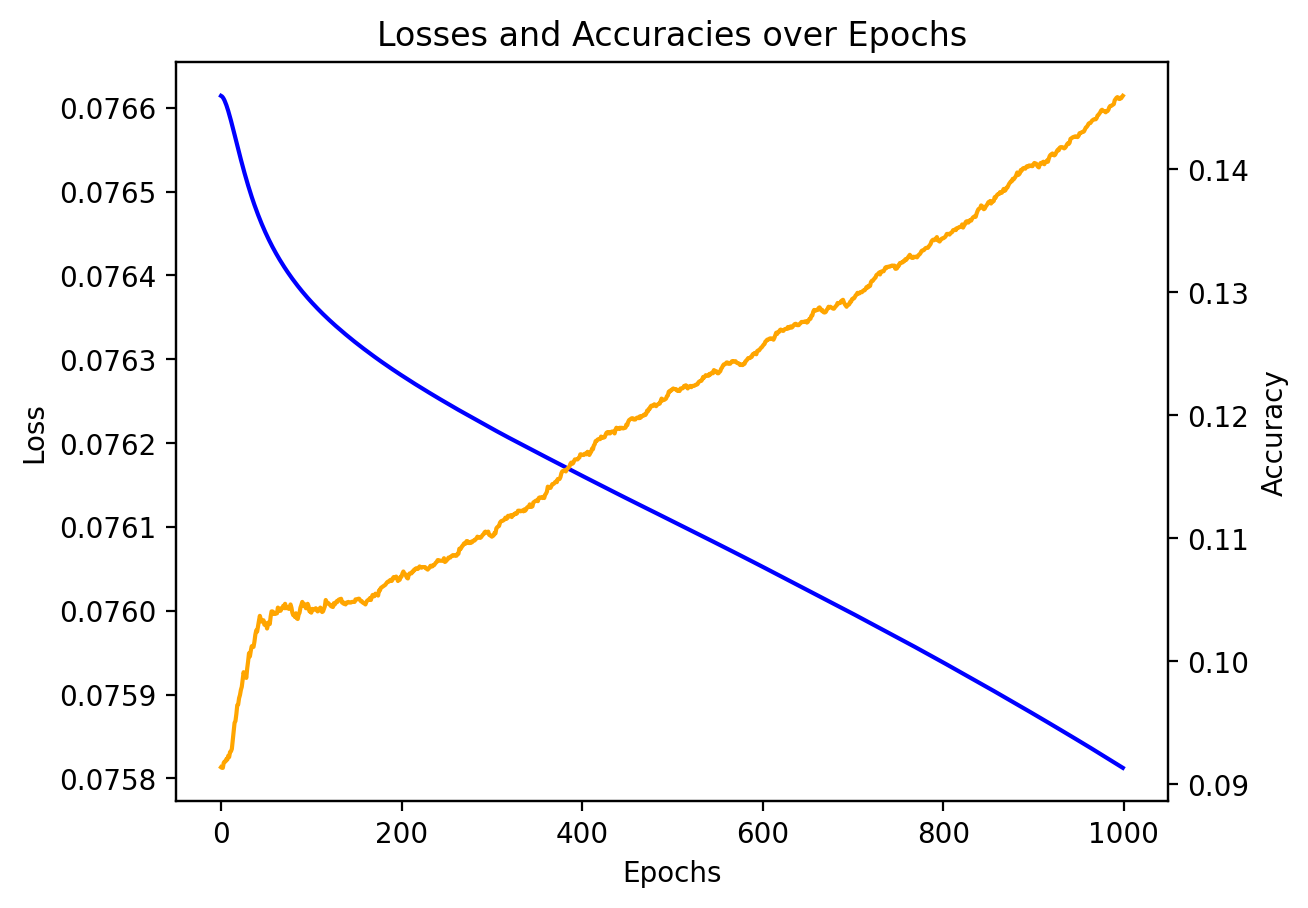

In [ ]:
note_model = Net().to(device)
optimizer = torch.optim.SGD(note_model.parameters(), lr=0.05, momentum=0.9)
loss_function = nn.MSELoss()

epochs = 1000
losses = []
accuracies = []
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    output = note_model(train_x)
    loss = loss_function(output, train_y)
    losses.append(loss.item())
    accuracies.append((output.argmax(1) == train_y.argmax(1)).float().mean().item())
    loss.backward()
    optimizer.step()
    if (epoch) % 100 == 0: print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracies[-1] * 100:.2f}%")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(losses, label='Loss', color='blue')
ax2.plot(accuracies, label='Accuracy', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.title('Losses and Accuracies over Epochs')
plt.show()


### 3.2.4 Testing

In [ ]:
with torch.no_grad():
    output = note_model(test_x)
    test_predictions = output.argmax(1)
    accuracy = (test_predictions == test_y.argmax(1)).float().mean().item()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test Loss: {loss.item():.2f}")

Test Accuracy: 11.85%
Test Loss: 0.08


## 4 The Music Algorithm

### 4.1 Call Me Maybe

In [62]:
music = muspy.read_midi("test/never_gonna_give_you_up.mid")
key = 62
for track in music.tracks:
    for note in track.notes:
        note.pitch += key
notes_per_bar = create_notes(music)

#### 4.1.1 Chord replacement

In [64]:
chord_model.eval()

chord_predictions = {}
for bar_count in notes_per_bar:
    notes_per_bar[bar_count]
    if bar_count < 4 or bar_count > len(notes_per_bar) - 4: continue
    vector =  np.zeros((8, 12))
    for i in range(1, 5):
        if bar_count - i in notes_per_bar:
            bar_notes_before = notes_per_bar[bar_count - i]
            for note in range(0, 12): vector[4-i][note] = int(note in bar_notes_before)

        if bar_count + i in notes_per_bar:
            bar_notes_after = notes_per_bar[bar_count + i]
            for note in range(0, 12): vector[3+i][note] = int(note in bar_notes_after)
    
    target_vector =  np.zeros(12)
    for note in range(0, 12): 
        target_vector[note] = int(note in notes_per_bar[bar_count])
    
    vector = torch.tensor(vector.flatten(), dtype=torch.float32).unsqueeze(0).to(device)
    prediction = chord_model(vector)
    prediction = prediction.round().detach().numpy().flatten()
    predicted_notes = [j for j, note in enumerate(prediction) if note == 1]
    chord_predictions[bar_count] = predicted_notes

print(chord_predictions)

{4: [0, 2, 3, 5, 7, 8, 10], 5: [0, 2, 3, 5, 7, 8, 10], 6: [0, 2, 3, 5, 7, 8, 10], 7: [0, 2, 3, 5, 7, 8, 10], 8: [0, 2, 3, 5, 7, 8, 10], 9: [0, 2, 3, 5, 7, 8, 10], 10: [0, 2, 3, 5, 7, 8, 10], 11: [0, 2, 3, 5, 7, 8, 10], 12: [0, 2, 3, 5, 7, 8, 10], 13: [0, 2, 3, 5, 7, 8, 10], 14: [0, 2, 3, 5, 7, 8, 10], 15: [0, 2, 3, 5, 7, 8, 10], 16: [0, 2, 3, 5, 7, 8, 10], 17: [0, 2, 3, 5, 7, 8, 10], 18: [0, 2, 3, 5, 7, 8, 10], 19: [0, 2, 3, 5, 7, 8, 10], 20: [0, 2, 3, 5, 7, 8, 10], 21: [0, 2, 3, 5, 7, 8, 10], 22: [0, 2, 3, 5, 7, 8, 10], 23: [0, 2, 3, 5, 7, 8, 10], 24: [0, 2, 3, 5, 7, 8, 10], 25: [0, 2, 3, 5, 7, 8, 10], 26: [0, 2, 3, 5, 7, 8, 10], 27: [0, 2, 3, 5, 7, 8, 10], 28: [0, 2, 3, 5, 7, 8, 10], 29: [0, 2, 3, 5, 7, 8, 10], 30: [0, 2, 3, 5, 7, 8, 10], 31: [0, 2, 3, 5, 7, 8, 10], 32: [0, 2, 3, 5, 7, 8, 10], 33: [0, 2, 3, 5, 7, 8, 10], 34: [0, 2, 3, 5, 7, 8, 10], 35: [0, 2, 3, 5, 7, 8, 10], 36: [0, 2, 3, 5, 7, 8, 10], 37: [0, 2, 3, 5, 7, 8, 10], 38: [0, 2, 3, 5, 7, 8, 10], 39: [0, 2, 3, 5, 7, 8, 10

#### 4.1.2 Note replacement

In [72]:
notes_and_chords = []
note_bars = []
for bar_count in notes_per_bar:
    if bar_count < 4 or bar_count > len(notes_per_bar) - 4: continue
    predicted_notes = chord_predictions[bar_count]
    for note in notes_per_bar[bar_count]:
        if note in predicted_notes: continue
        notes_and_chords.append((note, prediction, bar_count))

min_index = 5
max_index = len(notes_and_chords) - 4
notes = []
for i, (note, chord, bar_count) in enumerate(notes_and_chords):
    vector = np.zeros((3, 12))
    vector[0] = chord

    for j in range(1, 5):
        vector[1][j] = notes_and_chords[i - j][0] if i - j >= 0 else -1
        vector[2][j] = notes_and_chords[i + j][0] if i + j <= max_index else -1

    notes.append(vector.flatten())
    note_bars.append(bar_count)

notes = torch.tensor(notes, dtype=torch.float32).to(device)

predictions = note_model(notes)
predictions = predictions.round().detach().numpy().flatten()

predicted_notes = {}
for bar_count, prediction in zip(note_bars, predictions):
    if bar_count not in predicted_notes: predicted_notes[bar_count] = []
    predicted_notes[bar_count].append(prediction)

print(predicted_notes)

{4: [0.0], 5: [0.0], 6: [0.0], 7: [0.0], 8: [0.0], 9: [0.0], 10: [0.0, 0.0, 0.0], 11: [0.0], 12: [0.0], 13: [0.0], 14: [0.0], 15: [0.0], 16: [0.0], 17: [0.0], 18: [0.0, 0.0, 0.0], 19: [0.0], 20: [0.0], 21: [0.0], 22: [0.0, 0.0, 0.0], 23: [0.0], 24: [0.0], 25: [0.0], 26: [0.0], 27: [0.0], 28: [0.0], 29: [0.0], 30: [0.0, 0.0, 0.0], 31: [0.0], 32: [0.0], 33: [0.0], 34: [0.0], 35: [0.0], 36: [0.0], 37: [0.0], 38: [0.0, 0.0, 0.0], 39: [0.0], 40: [0.0], 41: [0.0], 42: [0.0, 0.0, 0.0], 43: [0.0], 44: [0.0], 45: [0.0], 46: [0.0], 47: [0.0], 48: [0.0], 49: [0.0], 50: [0.0, 0.0, 0.0], 51: [0.0], 52: [0.0], 53: [0.0], 54: [0.0], 55: [0.0], 56: [0.0], 57: [0.0], 58: [0.0, 0.0], 75: [0.0], 76: [0.0], 77: [0.0], 78: [0.0, 0.0, 0.0], 79: [0.0], 80: [0.0], 81: [0.0], 82: [0.0], 83: [0.0], 84: [0.0], 85: [0.0], 86: [0.0, 0.0, 0.0], 87: [0.0], 88: [0.0], 89: [0.0], 90: [0.0], 91: [0.0], 92: [0.0], 93: [0.0], 94: [0.0, 0.0], 95: [0.0], 96: [0.0], 97: [0.0], 98: [0.0], 99: [0.0], 59: [0.0], 60: [0.0], 61: